In [1]:
import random
import os
import sys
import pandas as pd
import torch
import torchaudio
import torch.nn.functional as F
import torchaudio.transforms as T
import librosa
import matplotlib.pyplot as plt
from IPython.display import Audio, display
import json
import numpy as np
import math
import seaborn as sns
sns.set_theme()
sns.set_style("ticks")
sns.set_context("paper")

from typing import Optional

from datetime import timedelta

from src.utils import (
    create_dataset, plot_spectrogram,
    RandomClip, extract_logmel, pad_tensor, plot_waveform
)
from src.datasets import VoxCelebDataModule
from src.models import SEBlock, SpeakerRecognitionModel, build_efficientnetv2
from torch import nn
from sklearn.decomposition import PCA

from src.losses import SubCenterAAMSoftmaxLoss
from sklearn.cluster import KMeans
from sklearn.metrics import roc_curve, accuracy_score
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier

from src.utils import (
    RandomBackgroundNoise, RandomClip, RandomSpeedChange,
    create_features_from_row, kmeans_plot
)
from tqdm.auto import tqdm
from pedalboard import Pedalboard, Reverb, Chorus

In [ ]:
SAMPLE_WAV_SPEECH_PATH = "E:\Datasets\VoxCeleb1\\vox1_dev\id10015\\7rzuEmfRFEA\\00001.wav"
waveform, sample_rate = torchaudio.load(SAMPLE_WAV_SPEECH_PATH)

In [ ]:
melspec = extract_logmel(waveform, n_mels=80)

In [ ]:
mfcc_t = torchaudio.transforms.MFCC(
    sample_rate=16000,
    n_mfcc=40
)

In [ ]:
mfcc = mfcc_t(waveform)

In [ ]:
plot_spectrogram(mfcc[0])

In [ ]:
spr = torchaudio.transforms.Spectrogram()
sprr = spr(waveform)

In [ ]:
sprr2 = librosa.feature.melspectrogram(
    y=waveform.numpy()[0],
    sr=16000,
    power=1
)

In [ ]:
plot_spectrogram(np.log(sprr2))

In [ ]:
SAMPLE_WAV_SPEECH_PATH = "/media/gabriele/Seagate Expansion Drive/Datasets/VoxCeleb1/vox1_dev/id10001/1zcIwhmdeo4/00001.wav"
waveform, sample_rate = torchaudio.load(SAMPLE_WAV_SPEECH_PATH)

In [ ]:
waveform, sample_rate

In [ ]:
waveform.shape

In [ ]:
reverb = Pedalboard(
    [Reverb(room_size=0.75)]
)

In [ ]:
board = Pedalboard([Chorus(), Reverb(room_size=0.25)])

In [ ]:
board(waveform, sample_rate=16000)

In [ ]:
reverb(waveform, sample_rate=16000)

In [ ]:
rc = RandomClip()

In [ ]:
clipped = rc(waveform)
clipped.shape

In [ ]:
n_fft = 512
mel_spectrogram = T.MelSpectrogram(
        sample_rate=sample_rate,
        n_fft=n_fft,
        win_length=400,
        hop_length=160,
        center=True,
        pad_mode="reflect",
        power=2.0, # energy instead of power
        norm="slaney",
        onesided=True,
        n_mels=80,
        mel_scale="htk",
    )

In [ ]:
cmn = T.SlidingWindowCmn(cmn_window=n_fft)
to_db = T.AmplitudeToDB(stype="amplitude")

In [ ]:
logmel = mel_spectrogram(clipped)
logmel.shape

In [ ]:
logmel

In [ ]:
logmel = extract_logmel(clipped, sample_rate=16000, n_mels=80)
logmel.shape

In [ ]:
logmel = torch.load("E:\Datasets\VoxCeleb1\subset\\features_3\\train\id10075\\08H4--mL1LQ\\00001_.pt")

In [ ]:
logeml = logmel + 1e-6
logeml = torch.log(logeml)
logmel = F.instance_norm(logmel)

In [ ]:
plot_spectrogram(melspec[0])

In [ ]:
freq_masking = T.FrequencyMasking(freq_mask_param=10)
time_masking = T.TimeMasking(time_mask_param=5)

In [ ]:
spec_logmel = time_masking(freq_masking(logmel))

In [ ]:
plot_spectrogram(time_masking(freq_masking(logmel))[0])

In [ ]:
num_secs = 3
csv_base_path: str = "E:/Datasets/VoxCeleb1/subset/"
label_dict = pd.read_csv(
    csv_base_path + f"subset_labels_{num_secs}.csv"
).to_dict()["label"]

In [ ]:
speaker_ids = list(label_dict.keys())
speaker_ids

In [ ]:
create_dataset(
    num_speakers=100, 
    to_db_flag=True,
    cmn_flag=True,
    clip_secs=6,
    n_fft=400,
    win_length=400,
    hop_length=160,
    n_mels=80,
    power=1.0,
    data_aug=True,
    speaker_ids=speaker_ids
    # base_path="/media/gabriele/Seagate Expansion Drive/Datasets/VoxCeleb1/",
    # noise_dir="/media/gabriele/Seagate Expansion Drive/Datasets/Musan/noise",
    # babble_dir="/media/gabriele/Seagate Expansion Drive/Datasets/Musan/speech"
)

In [ ]:
df = pd.read_csv("E:\Datasets\VoxCeleb1\subset\subset_labels_3.csv")
speaker_ids = df.index.tolist()

In [ ]:
create_dataset(
    num_speakers=5,
    clip_secs=6, 
    to_db_flag=True, 
    cmn_flag=True,
    speaker_ids=speaker_ids
    # base_path="/media/gabriele/Seagate Expansion Drive/Datasets/VoxCeleb1/",
    # noise_dir="/media/gabriele/Seagate Expansion Drive/Datasets/Musan/noise",
    # babble_dir="/media/gabriele/Seagate Expansion Drive/Datasets/Musan/speech"
)

In [ ]:
num_secs = 3
csv_base_path: str = "E:/Datasets/VoxCeleb1/subset/"
set_name: str = "train"
df = pd.read_csv(
            csv_base_path + f"subset_features_{num_secs}.csv"
        )

In [ ]:
df

In [ ]:
df_train = df[df["Set"] == "train"]
df_train

In [ ]:
label_dict = pd.read_csv(
            csv_base_path + f"subset_labels_{num_secs}.csv"
        ).to_dict()["label"]

In [ ]:
label_dict

In [ ]:
melspecs = []
y = []
for idx, row in df.iterrows():
    melspec = torch.load(row["File"]).numpy()
    melspecs.append(
        melspec
    )
    y.append(
        label_dict[row["Speaker"]]
    )

In [ ]:
X = np.vstack(melspecs)
X.shape

In [ ]:
X = X.reshape(X.shape[0], 80*301)
X.shape

In [ ]:
y = np.vstack(y).squeeze(-1)
y.shape

In [ ]:
kmeans = KMeans(n_clusters=8)

In [ ]:
kmeans.fit(X)

In [ ]:
pca = PCA(2)

In [ ]:
Xpca = pca.fit_transform(X)

In [ ]:
u_y = np.unique(y)

In [ ]:
y

In [ ]:
Xpca[y == 0]

In [ ]:
for label in u_y:
    plt.scatter(
        Xpca[y == label, 0], 
        Xpca[y == label, 1], 
        label=label,
        alpha=0.7
    )
plt.legend()
plt.show()

In [ ]:
svc = SVC()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [ ]:
svc.fit(X_train,y_train)

In [ ]:
pred = svc.predict(X_test)

In [ ]:
accuracy_score(y_test, pred)

In [ ]:
mlp = MLPClassifier()

In [ ]:
mlp.fit(X_train, y_train)

In [ ]:
pred = mlp.predict(X_test)

In [ ]:
accuracy_score(y_test, pred)

In [ ]:
optimizer = torch.optim.AdamW(
    [torch.randn((4,5))], 
    lr=1e-3, 
    eps=1e-8
)

In [ ]:
optimizer.state_dict()

In [ ]:
optimizer.state_dict()["param_groups"][0]

In [ ]:
import random
random.randint(0,4)

In [ ]:
waveform = torch.load(
    "E:\Datasets\VoxCeleb1\subset\\features_4\\train\id10206\\0dATli9-ofc\\00001_.pt"
)

In [ ]:
waveform.shape

In [ ]:
logmel = extract_logmel(waveform)

In [ ]:
logmel.shape

In [ ]:
res = pad_tensor(
    logmel, 401, 450
)

In [ ]:
res[0][1]

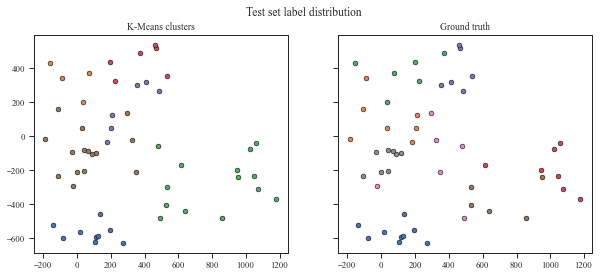

(array([[ -0.9530716 , -15.804745  , -15.432732  , ...,   8.744637  ,
           8.055164  ,   2.8258514 ],
        [  8.504242  ,  -3.4381752 ,  -3.911068  , ..., -26.499004  ,
         -34.671307  , -44.17028   ],
        [  2.2759209 ,  -1.3542252 ,  -4.5997314 , ..., -20.717422  ,
          -8.692635  ,  -8.274849  ],
        ...,
        [ -3.0026932 ,   1.024044  ,  -3.8014946 , ..., -27.546867  ,
         -28.556137  , -28.055107  ],
        [-25.266838  ,   0.5674057 , -10.369064  , ..., -15.710182  ,
         -15.493347  , -13.219742  ],
        [  0.89279175,  -7.4984207 ,  -4.1632156 , ..., -16.910526  ,
         -18.18077   , -16.921608  ]], dtype=float32),
 array([[ 270.05576 , -628.2515  ],
        [ 193.26863 , -553.4574  ],
        [ 114.46945 , -596.42084 ],
        [ -80.94694 , -600.3852  ],
        [ 107.57201 , -621.725   ],
        [  17.573442, -566.8375  ],
        [-140.21382 , -523.66833 ],
        [ 134.19495 , -459.51334 ],
        [ 125.94101 , -587.6766  ]

In [2]:
kmeans_plot()